In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import subprocess
import scipy.io as sio
import os
import time

%run './../split_step_fourier.ipynb'
DEBUG = False
DEBUG_PLOT = False

# showing figures inline
%matplotlib inline
# plotting options 
figure_size = (16, 9)
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
# parameters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10  # samples per symbol (>1 => oversampling)

r_rc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)
t_sample, ir = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)

P_in = 9 # dBm

# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 20 # number of symbols

# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)

# Sendesignal generieren
send_ir = generate_signal(modulation, t_sample, 1/f_symbol, send_bits, ir, syms_per_filt, n_symbol, P_in)

# add zeros before and after signal (use samples per symbol as factor)
send = add_zeros(send_ir, 10 * int(1/f_symbol/t_sample))

In [3]:
## Transmission parameters
z_length = 70  # [km]
nz = 10  # steps
dz = z_length / nz  # [km]

alpha = 0.2  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

# export inputs to matlab
sio.savemat('matlab/vars.mat', {'u0': send, 'dt': t_sample, 'dz': dz, 'nz': nz, 'alpha': alpha, 'betap': [0, 0, beta2], 'gamma': gamma})

In [4]:
# simulate python-transmission
start = time.time()
output = splitstepfourier(send, t_sample, dz, nz, alpha, beta2, gamma)
duration_python = (time.time() - start)
# simulate matlab-transmission
print("Please execute matlab.sh in ./matlab")

Please execute matlab.sh in ./matlab


In [5]:
# load matlab output
matlab = sio.loadmat('matlab/output.mat')
output_matlab = matlab['u'].flatten()
duration_matlab = matlab['duration'].flatten()[0]

Relativer Fehler: 0.0036148923667948395
Simulationsdauer Matlab: 0.166201 s
Simulationsdauer Python: 0.004416465759277344 s
Python is 37.63212692204707 times faster than Matlab


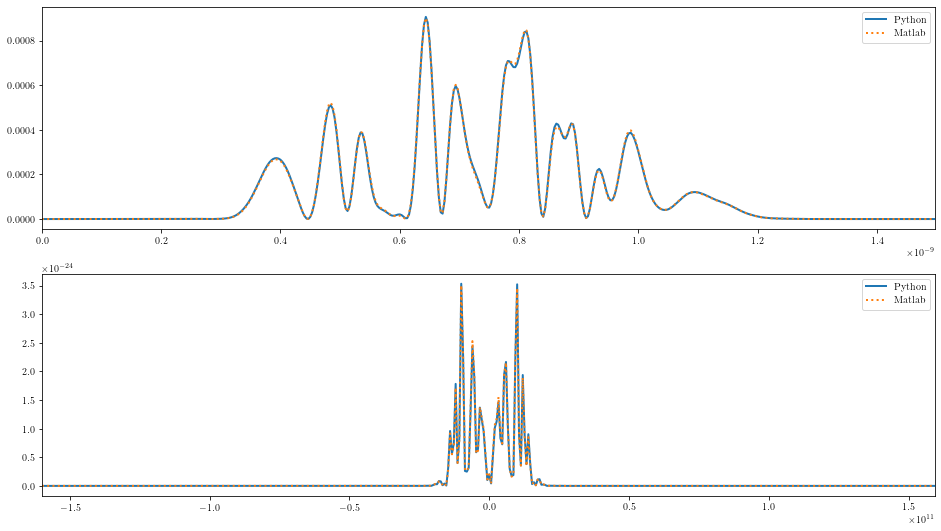

In [6]:
fig1, ax1 = plt.subplots(2, figsize=figure_size)

x_vals = np.arange(output.size)*t_sample
ax1[0].plot(x_vals, np.square(np.abs(output)), linewidth=2.0, label='Python')
ax1[0].plot(x_vals, np.square(np.abs(output_matlab)), linestyle=':', linewidth=2.0, label='Matlab')
ax1[0].legend()
ax1[0].set_xlim(np.amin(x_vals), np.amax(x_vals))

ax1[1].plot(np.fft.fftshift(np.fft.fftfreq(len(output),t_sample)), np.fft.fftshift(np.square(abs(t_sample*np.fft.fft(output)/np.sqrt(2*np.pi)))), linewidth=2.0,  label='Python')
ax1[1].plot(np.fft.fftshift(np.fft.fftfreq(len(output),t_sample)), np.fft.fftshift(np.square(abs(t_sample*np.fft.fft(output_matlab)/np.sqrt(2*np.pi)))), linestyle=':', linewidth=2.0, label='Matlab')
ax1[1].legend()
ax1[1].set_xlim(np.amin(np.fft.fftshift(np.fft.fftfreq(len(output),t_sample))), np.amax(np.fft.fftshift(np.fft.fftfreq(len(output),t_sample))))

print(f"Relativer Fehler: {calc_relerr(output, output_matlab)}")
print(f"Simulationsdauer Matlab: {duration_matlab} s")
print(f"Simulationsdauer Python: {duration_python} s")
print(f"Python is {duration_matlab/duration_python} times faster than Matlab")

In [7]:
output_fname = "compare_matlab"
output_path = "../../../bachelorarbeit-ausarbeitung/figures/plots/"

tikzplotlib.save(f'{output_path}{output_fname}.tex', figure=fig1, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)

fig1.savefig(f"{output_path}{output_fname}.pdf", bbox_inches='tight')